In [393]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
import pyforest


import os
import warnings
warnings.filterwarnings("ignore")


#importations des modèles de régression : 
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR, SVR

#importations modèles non linéaires 
from sklearn.kernel_ridge import KernelRidge

#model foret aleatoire :
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

# import package de mesure
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics.pairwise import rbf_kernel

#import packaging pour mesurer le temps :
import time

#import packaging pour améliorer model : 
from sklearn.model_selection import GridSearchCV, cross_val_score

# Plan : 

## Sur un échantillon de 1000 observations : 

### 1. Modélisation sans tSNE
- 1.1 Préparation de données
- 1.2 Création des fonctions de modélisation
- 1.3 Entrainement des modèles
- 1.4 Mesure des performances des modèles

### 2. Modélisation avec tSNE
- 2.1 Préparation de données
- 2.2 Entrainement des modèles
- 2.3 Mesure des performances des modèles
 
 ### conclusion 

# 1. Modélisation sans tSNE
## 1.1 Préparation de données

In [422]:
### Récupération des données
data = pd.read_csv("data_cleaned_without_tsne.csv", index_col = 0)
data_tsne = pd.read_csv("data_cleaned_tsne.csv",index_col = 0)

df = data.sample(1000, random_state=42).copy()
df_tsne = data_tsne.sample(1000, random_state=42).copy()

In [398]:
print("df shape :", df.shape)
print("df_tsne shape :", df_tsne.shape)

df shape : (1000, 61)
df_tsne shape : (1000, 17)


In [399]:
df.head()

,latitude,longitude,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_surface_albedo,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,year,week_no,emission
61907,-1.003487,-1.941012,1.264741,-0.492357,1.263167,1.220234,1.386444,-1.897006,-1.360678,0.972493,1.952447,-0.404294,1.031592,-0.368140,0.795099,0.819894,-1.441706,-0.740414,-0.003308,-0.000603,-0.003218,-0.003499,0.000580,-0.000841,-0.000532,-0.001430,-0.000213,0.001777,-0.035856,-1.321392,-0.440768,-1.327827,-1.779725,1.276157,1.479896,0.350854,0.476286,0.213828,-1.309341,-0.427674,-2.116430,0.032941,-1.008988,-0.897120,0.640191,0.490240,0.241354,-1.313418,-0.441000,0.767650,0.198052,-0.294381,0.299165,-0.367085,0.389718,0.134720,-1.290303,-0.390813,2020,3,0.966646
41543,-0.054793,-1.372517,-0.225027,0.433529,-0.298669,0.861779,0.411023,-1.136549,0.014684,-0.306440,-0.239592,0.407280,1.424888,0.837153,-0.724264,-0.872034,-0.824096,0.769813,0.418438,-0.499912,0.952370,-0.397482,0.509718,1.384041,1.248110,-1.397715,0.735960,-0.882981,0.408719,0.369590,0.553187,-0.018822,-1.057756,0.376920,0.458707,0.152122,-0.490167,0.096422,-0.914310,0.427820,0.561023,-0.244875,0.032632,0.118298,0.352481,-0.476491,0.123869,-0.917306,0.417501,-0.014531,-1.042988,1.202513,-1.129876,1.232229,0.647656,0.018912,-0.898979,0.450540,2019,44,11.951285
60915,-0.944553,-0.160142,0.194148,1.181888,0.378991,-0.764772,-0.091282,1.040267,0.478507,0.371795,-1.018803,0.094267,0.102560,0.952683,-0.481513,-0.011883,0.975474,0.779099,1.034334,-0.453686,-0.069871,-1.227102,-1.122608,-1.918585,0.609911,0.046622,-1.315432,1.088454,0.169991,0.401970,0.367387,0.422627,1.008889,-0.538790,-0.067167,0.802039,-0.478593,0.962769,1.026768,0.773030,0.604296,0.565904,0.784435,-0.863115,-1.390658,-1.081409,0.372016,0.943875,1.091397,-0.772924,0.528302,-0.615338,0.655311,-0.704444,2.932922,1.990928,0.904217,1.437013,2019,18,109.934456
28567,0.514423,-1.748218,0.003436,0.001859,0.003283,-0.002064,-0.002808,0.000758,0.001364,0.003044,-0.001077,-0.001202,0.000649,-0.000958,-0.001044,0.000083,0.000631,-0.000320,-0.003308,-0.000603,-0.003218,-0.003499,0.000580,-0.000841,-0.000532,-0.001430,-0.000213,0.001777,-0.002596,0.000940,-0.002699,0.000122,0.0006

In [400]:
df_tsne.head()

,F1_SulphurDioxide,F2_SulphurDioxide,F1_CarbonMonoxide,F2_CarbonMonoxide,F1_NitrogenDioxide,F2_NitrogenDioxide,F1_Formaldehyde,F2_Formaldehyde,F1_UvAerosolIndex,F2_UvAerosolIndex,F1_Ozone,F2_Ozone,F1_Cloud,F2_Cloud,year,week_no,emission
61907,25.464321,97.977000,60.777230,33.371033,-42.844360,-11.633705,21.649864,-92.746475,-67.226220,-90.676810,-20.000328,101.401080,39.665398,19.555437,2020,3,0.966646
41543,-69.808350,-17.290012,-18.310823,68.122050,15.313409,105.051125,-76.269810,-65.673670,77.045784,-32.401237,14.223171,40.891735,89.295380,-8.430561,2019,44,11.951285
60915,25.876163,-42.674866,-73.245890,-19.340183,19.230220,21.933563,12.221998,42.398724,68.645676,66.515680,71.619180,-25.079477,-68.430046,85.904380,2019,18,109.934456
28567,-23.432682,2.433769,-110.130840,11.826245,-14.467091,-8.916232,74.300390,5.435253,131.793200,-15.034699,120.720770,44.032303,99.855790,72.457565,2021,0,0.774535
49022,-82.073290,-8.104838,-22.278475,106.629740,-64.243070,56.137558,-99.047714,-39.610740,92.102615,-76.036194,60.758095,95.194230,28.868855,92.817910,2019,50,119.001120


In [401]:
X,y = df.drop("emission", axis = 1), df.emission
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.2 Création des fonctions de modélisation

In [402]:
#Création de la fonction d'entrainement d'un modèle
def training_model(model):
    """Création d'une fonction qui entraine un modèle donnée et qui renvoie différentes informations :
    - Affiche le score après une cross validation
    - Renvoi les prédictions du modèle
    - Renvoi la durée d'entrainement du modèle 
    - Renvoi le score (R²)
    - Renvoi le modèle préentrainé
    return : (y_pred, training_time, scoring,  model)
    """
    #Entrainement du modèle sur 5 splits par cross validation :
    scores = cross_val_score(estimator=model, X = X_train, y = y_train,
                             cv=5,scoring="neg_mean_squared_error")

    #Temps début d'entrainement :
    start_time = time.time()
    #Entrainement :
    model.fit(X_train,y_train)
    #Temps fin entrainement
    end_time = time.time()
    # Durée d'entrainement en minute :
    training_time = round((end_time - start_time)/60,2)
    
    #récupération des prédictions du modèle : 
    y_pred = model.predict(X_test)
    
    #Récupération des scores R²
    scoring = model.score(X_test,y_test)
    
    #Affichage du nom du modèle entrainé : 
    print("\n",type(model).__name__,) 
    print(f"\nAffichage du score sur les {len(scores)} splits :")
    print(f"{[i for i in scores.round(2)]}")
    
    return (y_pred, training_time, scoring, model)

In [403]:
def mesure(prediction, model):
    """
    Renvoi un dataframe contenant les valeurs des différentes 
    metrics enregistrées à partir des prédicions d'un modèle:
    RMSE,MSE,MAE & R²
    return : Dataframe
    """
    #Calcul des différentes metrics rmse,mse, mae,R²
    
    rmse = mean_squared_error(y_test, prediction, squared=False)
    mse = mean_squared_error(y_test, prediction, squared=True)

    mae = median_absolute_error(y_test, prediction) 

    
    #Récupération de l'ensemble des metrics
    all_metric = [rmse,mse, mae, ]
    index_metric = ["RMSE","MSE","MAE",]
    
    metric_series = pd.Series(all_metric, name=str(model), index =index_metric)
    
    return pd.DataFrame(metric_series).T

In [404]:
def visualisation_pred_real(model):
    """
    Fonction qui récupère les prédictions d'un modèle et affiche un graphique en comparant avec les valeurs réelles
    les valeurs réelles sont sur l'axe des x et les valeurs prédites sont sur l'axe des y.
    La ligne rouge en pointillés représente une correspondance parfaite entre les valeurs réelles et prédites. 
    Dans un modèle parfait, tous les points se situeraient le long de cette ligne.
    return : scatterplot
    """
    # Supposons que y_test contient les vraies valeurs et y_pred contient les valeurs prédites par votre modèle
    y_pred = model.predict(X_test)
    plt.figure(figsize=(10, 4))
    plt.scatter(y_test, y_pred, color='blue', alpha=0.5) #scatterplot avec les vraies valeurs en x et les valeurs prédites en y

    # Ajouter une ligne diagonale pour indiquer une correspondance parfaite entre les valeurs réelles et prédites
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

    # Label et  titre
    plt.title('Scatter Plot des Valeurs Réelles vs. Prédites')
    plt.xlabel('Valeurs Réelles')
    plt.ylabel('Valeurs Prédites')
    plt.show()


## 1.3 Entrainement des modèles

In [405]:
#Selection des modèles :
model_selected = [
                DummyRegressor(strategy="mean"), LinearRegression(),
                LinearSVR(),SVR(kernel="rbf"), RandomForestRegressor(),
                GradientBoostingRegressor()
                 ]

In [406]:
#Création des dictionnaires qui contiendront différentes informations :
dict_model = {} #contiendra les modèles préentrainés
dict_time = {} #contiendra les durées d'entrainement
dict_pred =  {} #contiendra les prédictions
dict_scoring = {} #contiendra les différents scores sur le test set (R²)
dict_metric = {} #contiendra les différentes metrics

In [407]:
#Création d'une boucle qui parcours l'ensemble des modèles selectionnés

for temp_model in model_selected:
    #récupérer le nom du modèle : 
    nom_model = type(temp_model).__name__
    
    pred, timing, scoring, model = training_model(temp_model) #récupération des prédictions, temps et du modèle 
    
    dict_pred[nom_model] = pred #récupération des prédictions
    dict_time[nom_model] = timing #récupération du temps d'entrainement
    dict_scoring[nom_model] = scoring #récupération des scores R²
    dict_model[nom_model] = model #récupération du modèle préentrainé
    
    # Pour les metrics :
    dict_metric[nom_model] = mesure(pred, nom_model) #ajout des metrics de notre fonction (MAE,RMSE,MSE)
    dict_metric[nom_model]["time"] = timing #rajout d'une colonne contenant le temps d'entrainement
    dict_metric[nom_model]["score"] = scoring #rajout du score
    dict_metric[nom_model] = dict_metric[nom_model].T #inversion colonne/index pour faciliter la lecture


 DummyRegressor

Affichage du score sur les 5 splits :
[-9793.02, -16020.26, -9472.91, -34741.19, -44551.0]

 LinearRegression

Affichage du score sur les 5 splits :
[-13473.62, -17890.94, -10715.12, -38449.22, -45067.05]

 LinearSVR

Affichage du score sur les 5 splits :
[-12086.89, -16428.44, -14701.26, -43637.64, -51478.68]

 SVR

Affichage du score sur les 5 splits :
[-10616.01, -17566.68, -10237.68, -37236.62, -46951.57]

 RandomForestRegressor

Affichage du score sur les 5 splits :
[-10832.55, -15809.72, -8922.81, -34337.7, -41995.1]

 GradientBoostingRegressor

Affichage du score sur les 5 splits :
[-9293.89, -13824.18, -8567.65, -31531.83, -34088.18]


## 1.4 Mesure des performances de modèle

In [408]:
#Transformation du dictionnaire des metrics en un dataframe complet :
metric_df = pd.concat(dict_metric.values(), axis = 1)
metric_df

,DummyRegressor,LinearRegression,LinearSVR,SVR,RandomForestRegressor,GradientBoostingRegressor
RMSE,86.697705,89.224182,108.366299,96.618799,82.733635,96.267732
MSE,7516.492020,7960.954714,11743.254691,9335.192310,6844.854376,9267.476213
MAE,64.025065,57.631387,41.346291,41.392733,44.768934,48.058962
time,0.000000,0.000000,0.000000,0.000000,0.220000,0.080000
score,-0.000618,-0.059786,-0.563298,-0.242729,0.088792,-0.233714


Vu l'ordre de grandeur de la MSE on va la séparer du reste

In [409]:
metric_no_mse = metric_df.drop("MSE", axis = 0)
metric_mse = metric_df.loc[["MSE"]]

In [410]:
# Réinitialisez d'abord l'index pour convertir l'index en colonne
metric_df_reset = metric_no_mse.reset_index()

# Ensuite, ON utilise melt avec le nouvel index comme id_vars
metric_df_melt = metric_df_reset.melt(id_vars="index", var_name="Model", value_name="Score")

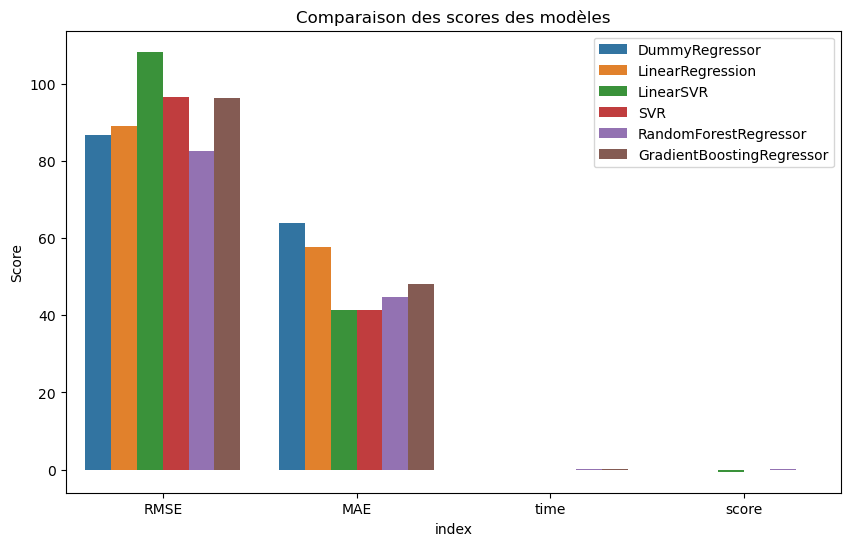

In [411]:

plt.figure(figsize=(10,6))
sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
plt.legend(bbox_to_anchor=(1,1))
plt.title('Comparaison des scores des modèles')  # Ajoutez cette ligne pour le titre
plt.show()

- Le temps d'execution pour tous les modèle est équivalent, presque instantané
- KernelRidge, LinearRegression et Ridge sont les modèles ayant la plus faible MSE (donc meilleurs modèles),
- on peut voir que SVR, LinearSVR et KNNRegressor ont des résultats qui sont moins bons que le DummyRegressor


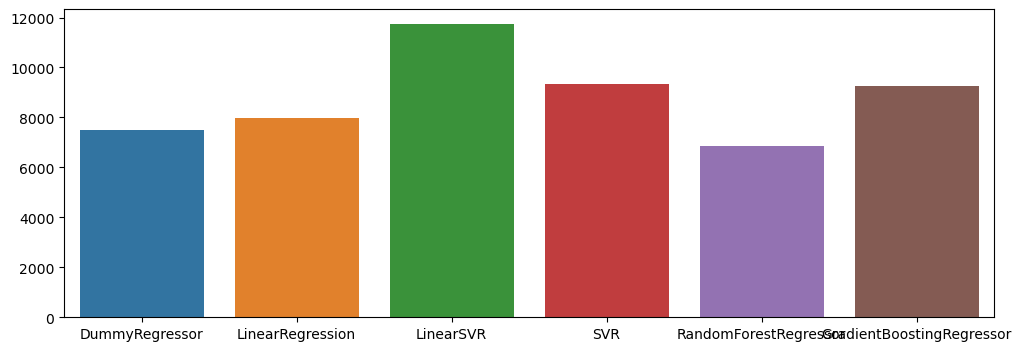

In [412]:
plt.figure(figsize=(12,4))
sns.barplot(data=metric_mse,)
plt.title("RMSE")
plt.show()
 

DummyRegressor


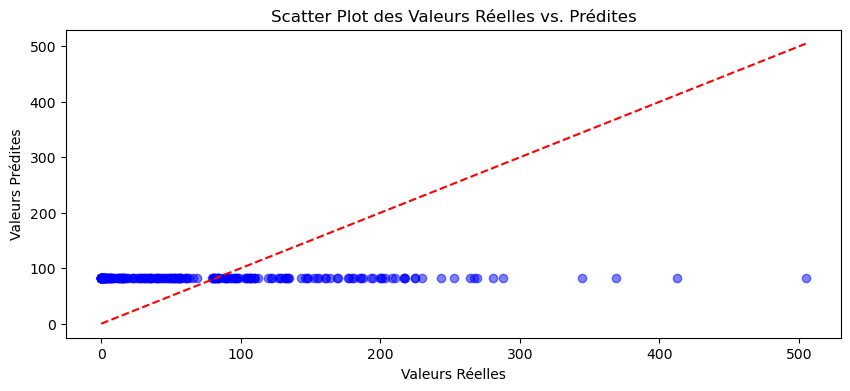

LinearRegression


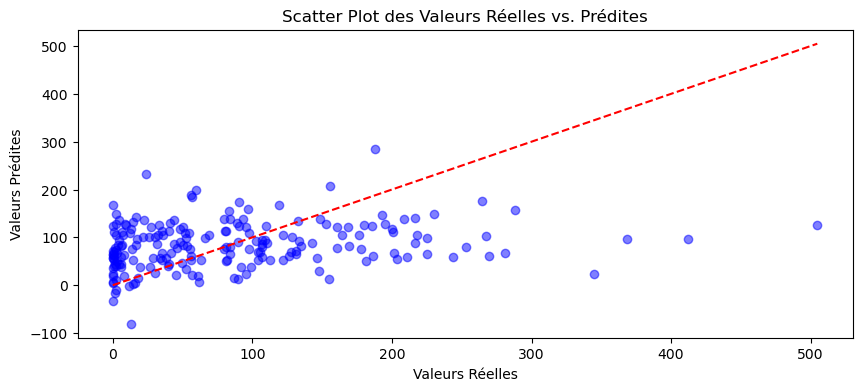

LinearSVR


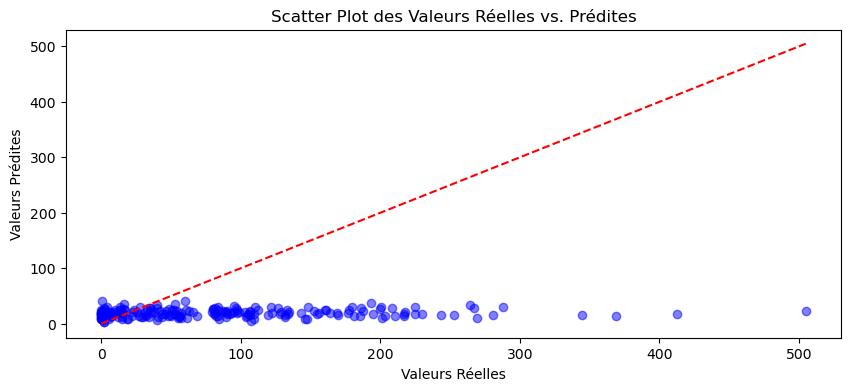

SVR


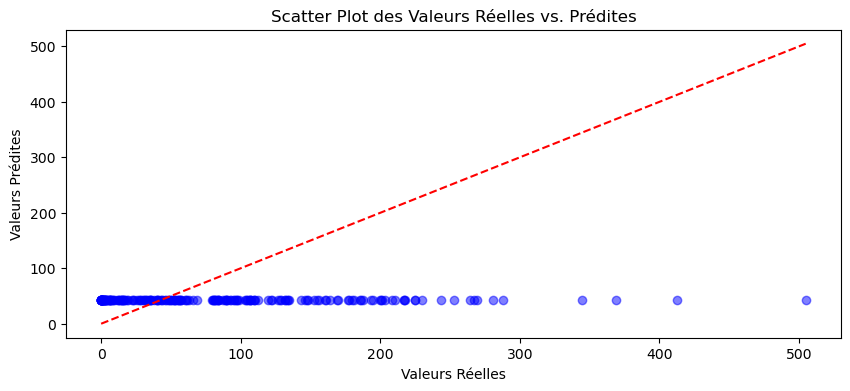

RandomForestRegressor


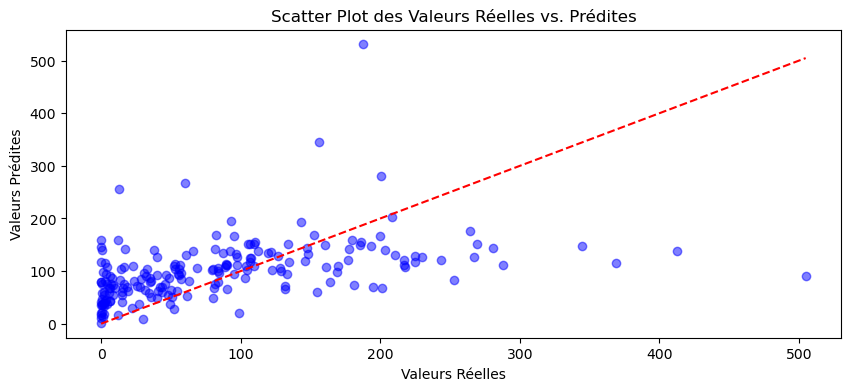

GradientBoostingRegressor


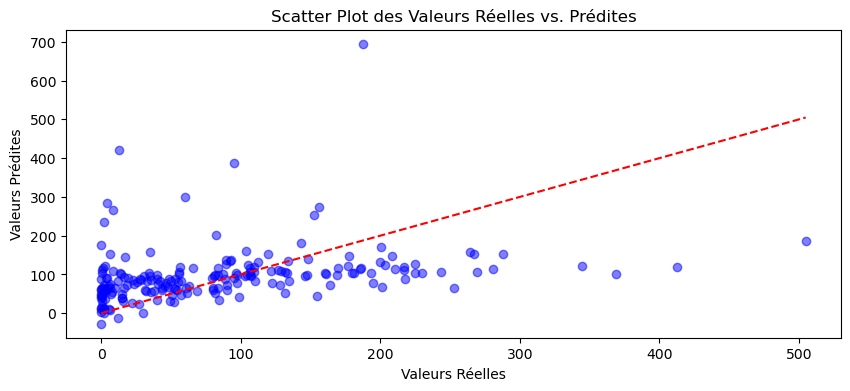

In [413]:
for i in dict_model:
    print(i)
    visualisation_pred_real(dict_model[i])

# Avec tSNE

## 2.1 Préparation de données


In [423]:
X,y = df_tsne.drop("emission", axis = 1), df_tsne.emission
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2.2 Entrainement des modèles

In [426]:
#Création des dictionnaires qui contiendront différentes informations :
dict_model = {} #contiendra les modèles préentrainés
dict_time = {} #contiendra les durées d'entrainement
dict_pred =  {} #contiendra les prédictions
dict_scoring = {} #contiendra les différents scores sur le test set (R²)
dict_metric = {} #contiendra les différentes metrics

In [427]:
#Création d'une boucle qui parcours l'ensemble des modèles selectionnés

for temp_model in model_selected:
    #récupérer le nom du modèle : 
    nom_model = type(temp_model).__name__
    
    pred, timing, scoring, model = training_model(temp_model) #récupération des prédictions, temps et du modèle 
    
    dict_pred[nom_model] = pred #récupération des prédictions
    dict_time[nom_model] = timing #récupération du temps d'entrainement
    dict_scoring[nom_model] = scoring #récupération des scores R²
    dict_model[nom_model] = model #récupération du modèle préentrainé
    
    # Pour les metrics :
    dict_metric[nom_model] = mesure(pred, nom_model) #ajout des metrics de notre fonction (MAE,RMSE,MSE)
    dict_metric[nom_model]["time"] = timing #rajout d'une colonne contenant le temps d'entrainement
    dict_metric[nom_model]["score"] = scoring #rajout du score
    dict_metric[nom_model] = dict_metric[nom_model].T #inversion colonne/index pour faciliter la lecture


 DummyRegressor

Affichage du score sur les 5 splits :
[-24019.59, -9644.41, -15127.6, -20335.11, -21511.72]

 LinearRegression

Affichage du score sur les 5 splits :
[-24079.0, -9601.73, -15088.76, -20320.59, -21578.59]

 LinearSVR

Affichage du score sur les 5 splits :
[-53740.52, -10292.4, -17489.53, -20483.45, -70632.63]

 SVR

Affichage du score sur les 5 splits :
[-25656.68, -10872.21, -16088.48, -21511.53, -22800.47]

 RandomForestRegressor

Affichage du score sur les 5 splits :
[-24943.14, -10163.41, -16124.46, -21597.4, -23883.9]

 GradientBoostingRegressor

Affichage du score sur les 5 splits :
[-25240.17, -10028.19, -15753.75, -21086.32, -27674.53]


## 2.3 Mesure des performances des modèles


In [428]:
#Transformation du dictionnaire des metrics en un dataframe complet :
metric_df = pd.concat(dict_metric.values(), axis = 1)
metric_df

,DummyRegressor,LinearRegression,LinearSVR,SVR,RandomForestRegressor,GradientBoostingRegressor
RMSE,161.833098,161.314963,171.273903,165.813050,156.657263,157.495561
MSE,26189.951563,26022.517226,29334.749764,27493.967445,24541.498199,24804.851727
MAE,61.671585,59.754628,30.708624,42.077014,54.066681,57.719151
time,0.000000,0.000000,0.010000,0.060000,1.430000,0.270000
score,-0.000019,0.006374,-0.120098,-0.049811,0.062924,0.052868


In [429]:
metric_no_mse = metric_df.drop("MSE", axis = 0)
metric_mse = metric_df.loc[["MSE"]]

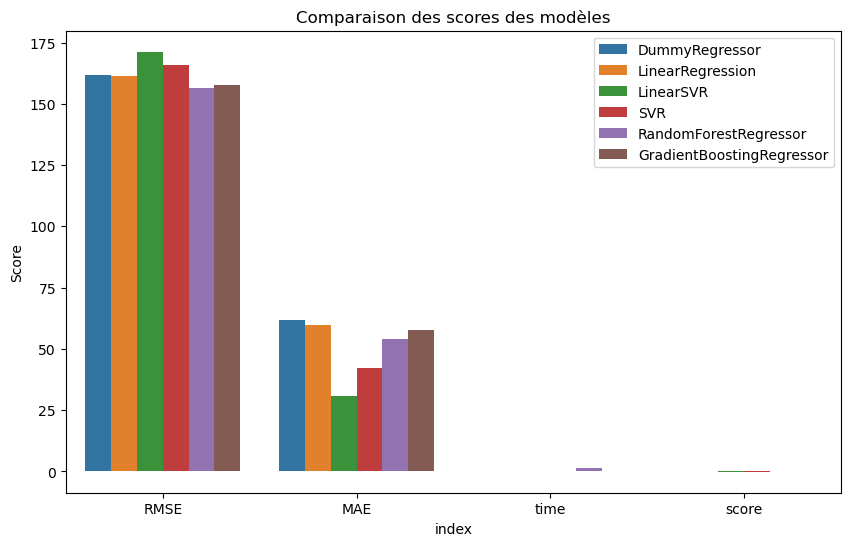

In [430]:
# Réinitialisez d'abord l'index pour convertir l'index en colonne
metric_df_reset = metric_no_mse.reset_index()

# Ensuite, ON utilise melt avec le nouvel index comme id_vars
metric_df_melt = metric_df_reset.melt(id_vars="index", var_name="Model", value_name="Score")

#
plt.figure(figsize=(10,6))
sns.barplot(data=metric_df_melt, x="index", y="Score", hue="Model")
plt.legend(bbox_to_anchor=(1,1))
plt.title('Comparaison des scores des modèles')  # Ajoutez cette ligne pour le titre
plt.show()


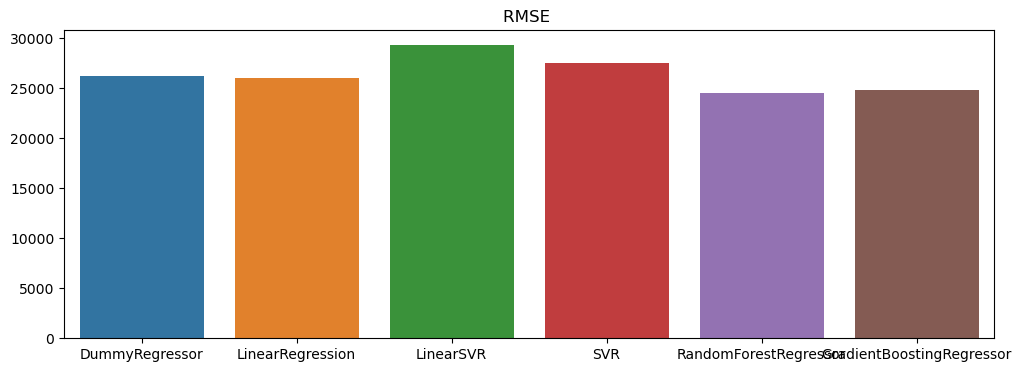

In [431]:
plt.figure(figsize=(12,4))
sns.barplot(data=metric_mse,)
plt.title("RMSE ")
plt.show()
 

### conclusion: 
- les résultats avec tSNE sont moins bon que sans la réduction

Prochain notebook, nous allons appliquer le même code sur l'ensemble des données, mais uniquement pour le jeu de données  sans TSNE